In [13]:
# dieSize

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [14]:
def solution1(x_test_df, train_df):
    # トレーニングデータの準備
    X_train = train_df[['dieSize']]
    y_train = train_df['failureType']

    # ラベルエンコーディング
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)

    # LightGBMモデルの設定とトレーニング
    lgbm = lgb.LGBMClassifier(num_leaves=50, max_depth=10, min_data_in_leaf=20, learning_rate=0.01)
    lgbm.fit(X_train, y_train_encoded)

    # テストデータの準備
    X_test = x_test_df[['dieSize']]

    # テストデータに対する予測
    y_pred_encoded = lgbm.predict(X_test)

    # エンコードされた予測を元のラベルに変換
    y_pred = le.inverse_transform(y_pred_encoded)

    # 予測結果をデータフレームに変換
    result_df = pd.DataFrame(y_pred, index=x_test_df.index, columns=['failureType'])
    return result_df



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 22967, number of used features: 1
[LightGBM] [Info] Start training from score -1.782097
[LightGBM] [Info] Start training from score -3.829208
[LightGBM] [Info] Start training from score -1.592899
[LightGBM] [Info] Start training from score -0.969357
[LightGBM] [Info] Start training from score -1.960339
[LightGBM] [Info] Start training from score -5.143974
[LightGBM] [Info] Start training from score -3.383803
[LightGBM] [Info] Start training from score -3.062668
[LightGBM] [Warning] min_data_in_leaf

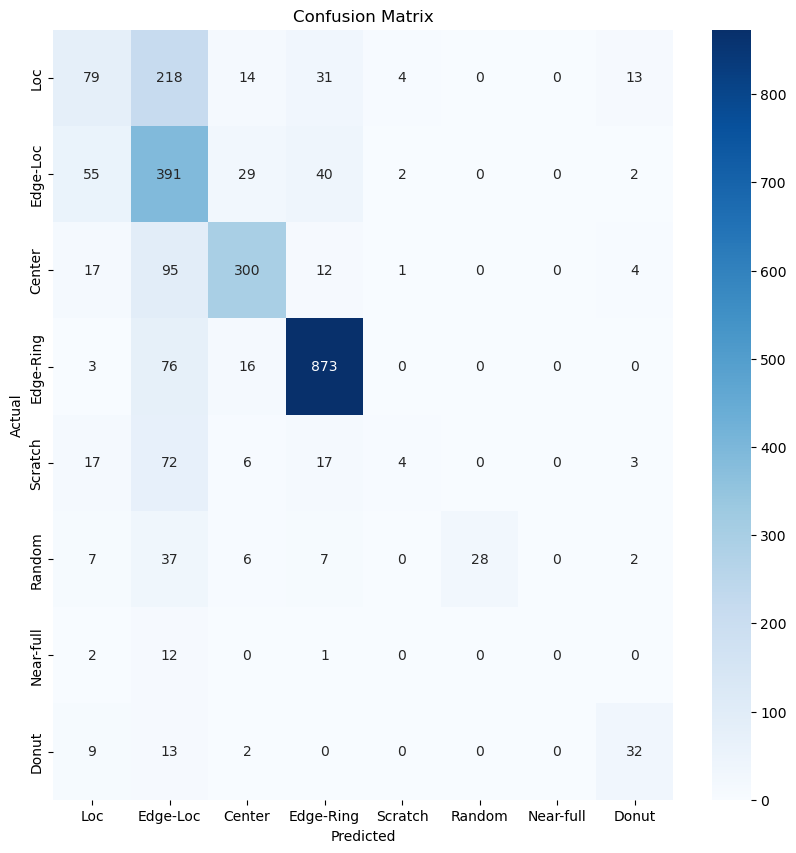


Class Accuracy and Most Common Errors:
Loc: Accuracy: 22.01%
    Most common error: Mistaken for Loc (22.01%)
Edge-Loc: Accuracy: 75.34%
    Most common error: Mistaken for Loc (10.60%)
Center: Accuracy: 69.93%
    Most common error: Mistaken for Edge-Loc (22.14%)
Edge-Ring: Accuracy: 90.19%
    Most common error: Mistaken for Edge-Loc (7.85%)
Scratch: Accuracy: 3.36%
    Most common error: Mistaken for Edge-Ring (14.29%)
Random: Accuracy: 32.18%
    Most common error: Mistaken for Random (32.18%)
Near-full: Accuracy: 0.00%
    Most common error: Mistaken for Loc (13.33%)
Donut: Accuracy: 57.14%
    Most common error: Mistaken for Edge-Loc (23.21%)
平均精度：43.77%
7.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [15]:
%%timeit -r 1 -n 1

def plot_confusion_matrix_and_accuracy(y_true, y_pred, classes):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    # Confusion matrixの計算
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # ヒートマップとしてプロット
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # 各クラスごとの正確さと最も間違えやすいクラスを表示
    print("\nClass Accuracy and Most Common Errors:")
    for i, class_name in enumerate(classes):
        accuracy = cm[i, i] / cm[i, :].sum()
        print(f"{class_name}: Accuracy: {accuracy * 100:.2f}%")
        
        # 最も間違えやすいクラスを特定
        error_indices = cm[i, :].argsort()[-2:-1] if accuracy < 1 else []
        for error_index in error_indices:
            error_rate = cm[i, error_index] / cm[i, :].sum()
            error_class = classes[error_index]
            print(f"    Most common error: Mistaken for {error_class} ({error_rate * 100:.2f}%)")

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution1(x_test_df, train_df)
plot_confusion_matrix_and_accuracy(y_test_df['failureType'], user_result_df['failureType'], df['failureType'].unique())

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))
    
    average_accuracy = sum(accuracies.values())/len(accuracies)
print(f"平均精度：{average_accuracy*100:.2f}%")

In [64]:
# lotName

In [65]:
def solution2(x_test_df, train_df):
    # lotNameから数値部分を抽出
    extract_lot_number = lambda lot: int(''.join(filter(str.isdigit, lot)))

    # トレーニングデータの準備
    X_train = train_df['lotName'].apply(extract_lot_number).to_frame()
    y_train = train_df['failureType']

    # ラベルエンコーディング
    le_label = LabelEncoder()
    y_train_encoded = le_label.fit_transform(y_train)

    # LightGBMモデルの設定とトレーニング
    lgbm = lgb.LGBMClassifier()
    lgbm.fit(X_train, y_train_encoded)

    # テストデータの準備
    X_test = x_test_df['lotName'].apply(extract_lot_number).to_frame()

    # テストデータに対する予測
    y_pred_encoded = lgbm.predict(X_test)

    # エンコードされた予測を元のラベルに変換
    y_pred = le_label.inverse_transform(y_pred_encoded)

    # 予測結果をデータフレームに変換
    result_df = pd.DataFrame(y_pred, index=x_test_df.index, columns=['failureType'])
    return result_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 22967, number of used features: 1
[LightGBM] [Info] Start training from score -1.782097
[LightGBM] [Info] Start training from score -3.829208
[LightGBM] [Info] Start training from score -1.592899
[LightGBM] [Info] Start training from score -0.969357
[LightGBM] [Info] Start training from score -1.960339
[LightGBM] [Info] Start training from score -5.143974
[LightGBM] [Info] Start training from score -3.383803
[LightGBM] [Info] Start training from score -3.062668


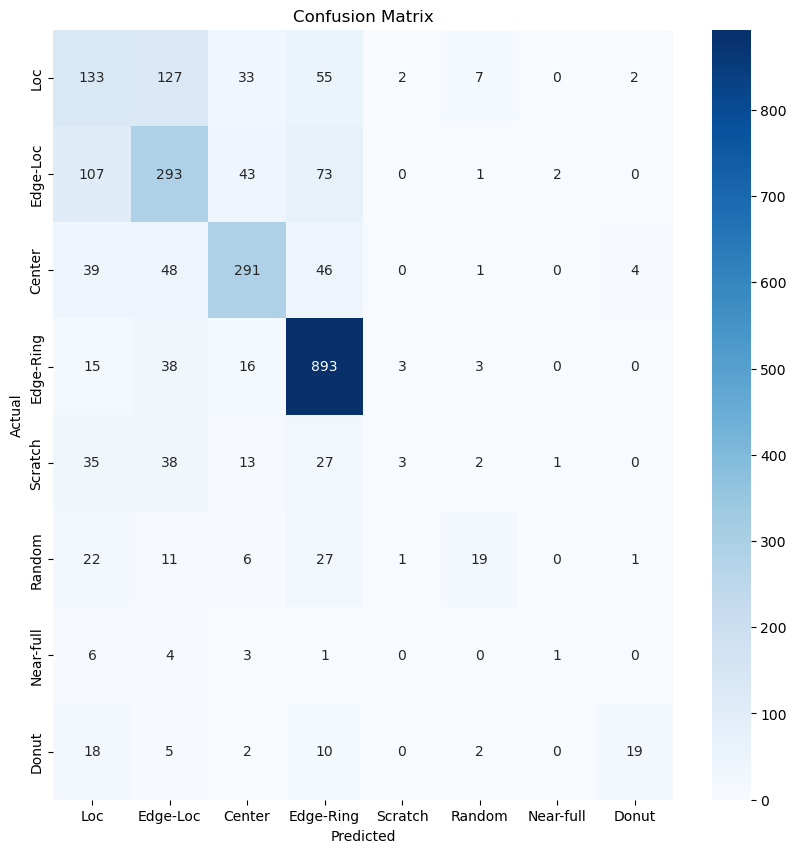


Class Accuracy and Most Common Errors:
Loc: Accuracy: 37.05%
    Most common error: Mistaken for Edge-Loc (35.38%)
Edge-Loc: Accuracy: 56.45%
    Most common error: Mistaken for Loc (20.62%)
Center: Accuracy: 67.83%
    Most common error: Mistaken for Edge-Loc (11.19%)
Edge-Ring: Accuracy: 92.25%
    Most common error: Mistaken for Edge-Loc (3.93%)
Scratch: Accuracy: 2.52%
    Most common error: Mistaken for Loc (29.41%)
Random: Accuracy: 21.84%
    Most common error: Mistaken for Loc (25.29%)
Near-full: Accuracy: 6.67%
    Most common error: Mistaken for Edge-Loc (26.67%)
Donut: Accuracy: 33.93%
    Most common error: Mistaken for Loc (32.14%)
平均精度：39.82%
1.37 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [66]:
%%timeit -r 1 -n 1
def plot_confusion_matrix_and_accuracy(y_true, y_pred, classes):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    # Confusion matrixの計算
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # ヒートマップとしてプロット
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # 各クラスごとの正確さと最も間違えやすいクラスを表示
    print("\nClass Accuracy and Most Common Errors:")
    for i, class_name in enumerate(classes):
        accuracy = cm[i, i] / cm[i, :].sum()
        print(f"{class_name}: Accuracy: {accuracy * 100:.2f}%")
        
        # 最も間違えやすいクラスを特定
        error_indices = cm[i, :].argsort()[-2:-1] if accuracy < 1 else []
        for error_index in error_indices:
            error_rate = cm[i, error_index] / cm[i, :].sum()
            error_class = classes[error_index]
            print(f"    Most common error: Mistaken for {error_class} ({error_rate * 100:.2f}%)")

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution2(x_test_df, train_df)
plot_confusion_matrix_and_accuracy(y_test_df['failureType'], user_result_df['failureType'], df['failureType'].unique())

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))
    
    average_accuracy = sum(accuracies.values())/len(accuracies)
print(f"平均精度：{average_accuracy*100:.2f}%")

In [67]:
def solution3(x_test_df, train_df):
    # lotNameから数値部分を抽出する関数
    extract_lot_number = lambda lot: int(''.join(filter(str.isdigit, lot)))

    # トレーニングデータの準備
    X_train = train_df[['dieSize']].copy()
    X_train['lotNumber'] = train_df['lotName'].apply(extract_lot_number)
    y_train = train_df['failureType']

    # ラベルエンコーディング
    le_label = LabelEncoder()
    y_train_encoded = le_label.fit_transform(y_train)

    # LightGBMモデルの設定とトレーニング
    lgbm = lgb.LGBMClassifier()
    lgbm.fit(X_train, y_train_encoded)

    # テストデータの準備
    X_test = x_test_df[['dieSize']].copy()
    X_test['lotNumber'] = x_test_df['lotName'].apply(extract_lot_number)

    # テストデータに対する予測
    y_pred_encoded = lgbm.predict(X_test)

    # エンコードされた予測を元のラベルに変換
    y_pred = le_label.inverse_transform(y_pred_encoded)

    # 予測結果をデータフレームに変換
    result_df = pd.DataFrame(y_pred, index=x_test_df.index, columns=['failureType'])
    return result_df


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 465
[LightGBM] [Info] Number of data points in the train set: 22967, number of used features: 2
[LightGBM] [Info] Start training from score -1.782097
[LightGBM] [Info] Start training from score -3.829208
[LightGBM] [Info] Start training from score -1.592899
[LightGBM] [Info] Start training from score -0.969357
[LightGBM] [Info] Start training from score -1.960339
[LightGBM] [Info] Start training from score -5.143974
[LightGBM] [Info] Start training from score -3.383803
[LightGBM] [Info] Start training from score -3.062668


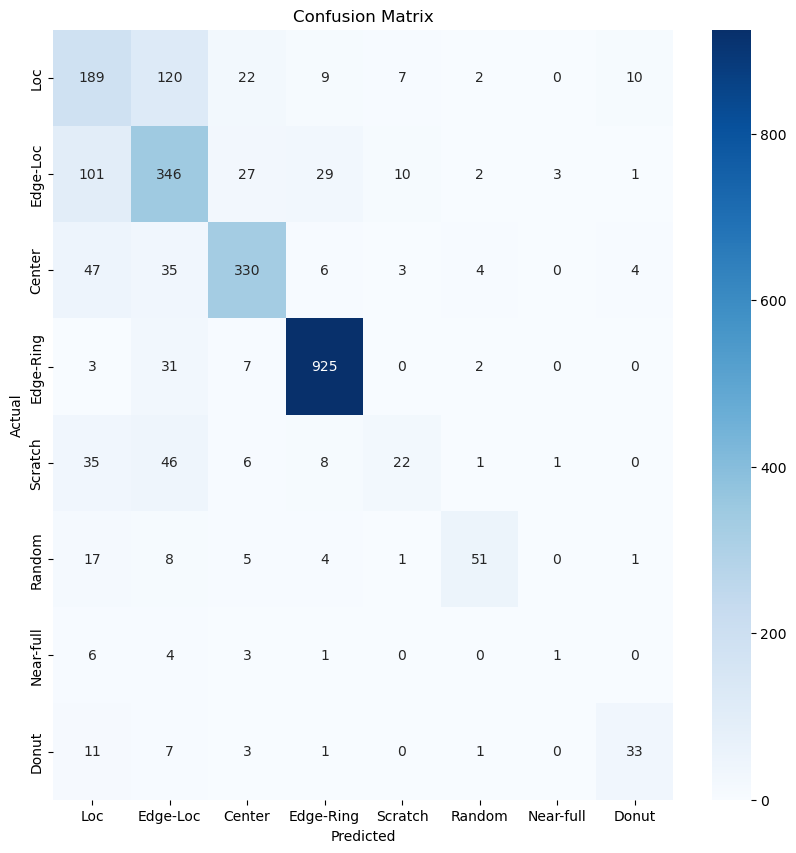


Class Accuracy and Most Common Errors:
Loc: Accuracy: 52.65%
    Most common error: Mistaken for Edge-Loc (33.43%)
Edge-Loc: Accuracy: 66.67%
    Most common error: Mistaken for Loc (19.46%)
Center: Accuracy: 76.92%
    Most common error: Mistaken for Loc (10.96%)
Edge-Ring: Accuracy: 95.56%
    Most common error: Mistaken for Edge-Loc (3.20%)
Scratch: Accuracy: 18.49%
    Most common error: Mistaken for Loc (29.41%)
Random: Accuracy: 58.62%
    Most common error: Mistaken for Loc (19.54%)
Near-full: Accuracy: 6.67%
    Most common error: Mistaken for Edge-Loc (26.67%)
Donut: Accuracy: 58.93%
    Most common error: Mistaken for Loc (19.64%)
平均精度：54.31%
1.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [70]:
%%timeit -r 1 -n 1
def plot_confusion_matrix_and_accuracy(y_true, y_pred, classes):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    # Confusion matrixの計算
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # ヒートマップとしてプロット
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # 各クラスごとの正確さと最も間違えやすいクラスを表示
    print("\nClass Accuracy and Most Common Errors:")
    for i, class_name in enumerate(classes):
        accuracy = cm[i, i] / cm[i, :].sum()
        print(f"{class_name}: Accuracy: {accuracy * 100:.2f}%")
        
        # 最も間違えやすいクラスを特定
        error_indices = cm[i, :].argsort()[-2:-1] if accuracy < 1 else []
        for error_index in error_indices:
            error_rate = cm[i, error_index] / cm[i, :].sum()
            error_class = classes[error_index]
            print(f"    Most common error: Mistaken for {error_class} ({error_rate * 100:.2f}%)")

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution3(x_test_df, train_df)
plot_confusion_matrix_and_accuracy(y_test_df['failureType'], user_result_df['failureType'], df['failureType'].unique())

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))
    
    average_accuracy = sum(accuracies.values())/len(accuracies)
print(f"平均精度：{average_accuracy*100:.2f}%")

In [37]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [38]:
def resize_map(map):
    from PIL import Image
    resize_shape = (224, 224)
    
    # マップの次元を取得
    len_y, len_x = map.shape

    # マップの中心y座標とx座標を取得
    y_add = len_y // 2 + len_y % 2
    x_add = len_x // 2 + len_x % 2

    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(map == 0)
    # 他の位置に置換
    map[y_indices, x_indices] = map[(y_indices + y_add) % len_y, (x_indices + x_add) % len_x]
    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(map == 0)
    # 0の値を置換
    map[y_indices, x_indices] = 1

    # リサイズし1を減算
    map = Image.fromarray(map - 1.0)
    # mapから1を減算してPILイメージを作成
    resized_map = map.resize(resize_shape, Image.LANCZOS)

    return np.asarray(resized_map)


def edge_detection_features(image):
    import cv2

    # imageの値を0-255の範囲にスケーリング
    scaled_image = np.uint8(image * 255)

    # Cannyエッジ検出を適用
    edges = cv2.Canny(scaled_image, threshold1=100, threshold2=150)

    # エッジ検出結果から特徴量を抽出
    total_edge_strength = np.sum(edges)

    return [total_edge_strength]


def normalize_map(map):
    from PIL import Image

    # リサイズ後のサイズを指定
    resize_shape = (32, 32)
    
    # マップの次元を取得
    len_y, len_x = map.shape

    # マップの中心y座標とx座標を取得
    y_add = len_y // 2 + len_y % 2
    x_add = len_x // 2 + len_x % 2

    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(map == 0)
    # 他の位置に置換
    map[y_indices, x_indices] = map[(y_indices + y_add) % len_y, (x_indices + x_add) % len_x]
    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(map == 0)
    # 0の値を置換
    map[y_indices, x_indices] = 1

    # リサイズし1を減算
    map = Image.fromarray(map - 1.0)
    # mapから1を減算してPILイメージを作成
    resized_map = map.resize(resize_shape, Image.LANCZOS)

    return np.asarray(resized_map)


def preprocess_map(df, normalize_map):
    # データの正規化
    train_maps = np.array([normalize_map(x) for x in df['waferMap']])

    # 1. 画像を水平方向に反転
    flipped_horizontally = np.flip(train_maps, axis=2)
    train_maps = np.concatenate((train_maps, flipped_horizontally), axis=0)

    # # 2. 画像を垂直方向に反転
    # flipped_vertically = np.flip(train_maps, axis=1)
    # train_maps = np.concatenate((train_maps, flipped_vertically), axis=0)

    # 3. 画像を90度回転
    rotated_90 = np.rot90(train_maps, k=1, axes=(1, 2))
    train_maps = np.concatenate((train_maps, rotated_90), axis=0)

    # 4. 画像を180度回転
    rotated_180 = np.rot90(train_maps, k=2, axes=(1, 2))
    train_maps = np.concatenate((train_maps, rotated_180), axis=0)

    # # 5. 画像を270度回転
    # rotated_270 = np.rot90(train_maps, k=3, axes=(1, 2))
    # train_maps = np.concatenate((train_maps, rotated_270), axis=0)

    # データの形状を変更
    train_maps = train_maps.reshape(train_maps.shape + (1,))

    return train_maps


def create_model(input_shape, num_classes):
    import tensorflow as tf

    model = tf.keras.models.Sequential([
        # 畳み込みブロック1
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same', input_shape=(input_shape)),
        tf.keras.layers.MaxPooling2D(pool_size=2, padding='same'),

        # 畳み込みブロック2
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),

        # 畳み込みブロック3
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),

        # ブロック4
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0),
        tf.keras.layers.Dense(16, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0),

        # 出力層
        tf.keras.layers.Dense(num_classes),
    ])

    return model


# def calculate_class_weights(train_labels):
#     from sklearn.utils.class_weight import compute_class_weight
#     # クラスの重みを計算
#     class_weights = compute_class_weight(
#         class_weight='balanced', 
#         classes=np.unique(train_labels),
#         y=train_labels)
#     # クラスの重みを辞書型に変換
#     return dict(enumerate(class_weights))


def solution(x_test_df, train_df):
    import os
    import tensorflow as tf
    import lightgbm as lgb
    from sklearn.preprocessing import LabelEncoder

    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

    # train_dfからユニークな故障タイプをリストとして取得
    failure_types = list(train_df['failureType'].unique())

    # train_dfのウエハマップを正規化し、データ拡張を行う
    train_maps = preprocess_map(train_df, normalize_map)

    # train_dfの故障タイプラベルを数値化し、データ拡張に合わせて複製
    train_labels = np.array([failure_types.index(x) for x in train_df['failureType']] * 8)

    # 各クラスの重みを計算し、不均衡なデータセットに対応
    # class_weights = calculate_class_weights(train_labels)

    # 早期停止コールバックを設定し、過学習を防ぐ
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # CNNモデルを作成し、コンパイル後、トレーニングを実施
    model = create_model((32, 32, 1), len(failure_types))
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.fit(train_maps, train_labels, epochs=10, callbacks=[early_stopping], validation_split=0.2)

    # x_test_dfのウエハマップを正規化し、CNNモデルで予測を実行
    test_maps = preprocess_map(x_test_df, normalize_map)
    test_logits = np.mean(model.predict(test_maps).reshape(-1, len(x_test_df['waferMap']), len(failure_types)), axis=0)
    predictions = tf.nn.softmax(test_logits).numpy()
    predicted_classes = [failure_types[x.argmax()] for x in predictions]

    # # train_dfとx_test_dfのwaferMap列に対してedge_detection_features関数を適用
    # train_df['waferMapEdges'] = train_df['waferMap'].apply(edge_detection_features)
    # x_test_df['waferMapEdges'] = x_test_df['waferMap'].apply(edge_detection_features)

    # # 各エッジ特徴量を個別の列に分割
    # train_df[['waferMapEdges']] = pd.DataFrame(train_df['waferMapEdges'].tolist(), index=train_df.index)
    # x_test_df[['waferMapEdges']] = pd.DataFrame(x_test_df['waferMapEdges'].tolist(), index=x_test_df.index)

    # # train_dfとx_test_dfからlotNameから数値部分を抽出し、新しい列として追加
    # train_df['lotNumber'] = train_df['lotName'].str.extract('(\d+)').astype(int)
    # x_test_df['lotNumber'] = x_test_df['lotName'].str.extract('(\d+)').astype(int)

    # # CNNモデルの予測の中で信頼度が低いものを選定
    # low_confidence_indices = [i for i, x in enumerate(predictions) if max(x) < 0.85]

    # if low_confidence_indices:
    #     # 低信頼度の予測に対してLightGBMを使い再分類
    #     X_train = train_df[['dieSize', 'lotNumber']]
    #     y_train = train_df['failureType']
    #     le = LabelEncoder()
    #     y_train_encoded = le.fit_transform(y_train)
    #     lgbm = lgb.LGBMClassifier(num_leaves=50, max_depth=10, min_data_in_leaf=20, learning_rate=0.01)
    #     lgbm.fit(X_train, y_train_encoded)

    #     # 低信頼度の予測に対して再分類を行い、新たな予測を取得
    #     X_test_reclassify = x_test_df.loc[x_test_df.index.isin(low_confidence_indices), ['dieSize', 'lotNumber']]
    #     reclassified_preds_encoded = lgbm.predict(X_test_reclassify)
    #     reclassified_preds = le.inverse_transform(reclassified_preds_encoded)

    #     for idx, new_pred in zip(X_test_reclassify.index, reclassified_preds):
    #         predicted_classes[idx] = new_pred

    return pd.DataFrame({'failureType': predicted_classes}, index=x_test_df.index)

Epoch 1/10
4594/4594 [==============================] - 55s 12ms/step - loss: 0.3210 - accuracy: 0.8801 - val_loss: 0.2321 - val_accuracy: 0.9149
Epoch 2/10
4594/4594 [==============================] - 53s 12ms/step - loss: 0.1849 - accuracy: 0.9298 - val_loss: 0.1899 - val_accuracy: 0.9275
Epoch 3/10
4594/4594 [==============================] - 55s 12ms/step - loss: 0.1546 - accuracy: 0.9413 - val_loss: 0.1618 - val_accuracy: 0.9386
Epoch 4/10
4594/4594 [==============================] - 53s 12ms/step - loss: 0.1377 - accuracy: 0.9476 - val_loss: 0.1622 - val_accuracy: 0.9382
Epoch 5/10
4594/4594 [==============================] - 52s 11ms/step - loss: 0.1265 - accuracy: 0.9521 - val_loss: 0.1535 - val_accuracy: 0.9420
Epoch 6/10
4594/4594 [==============================] - 55s 12ms/step - loss: 0.1177 - accuracy: 0.9544 - val_loss: 0.1451 - val_accuracy: 0.9456
Epoch 7/10
4594/4594 [==============================] - 58s 13ms/step - loss: 0.1100 - accuracy: 0.9570 - val_loss: 0.1464 -

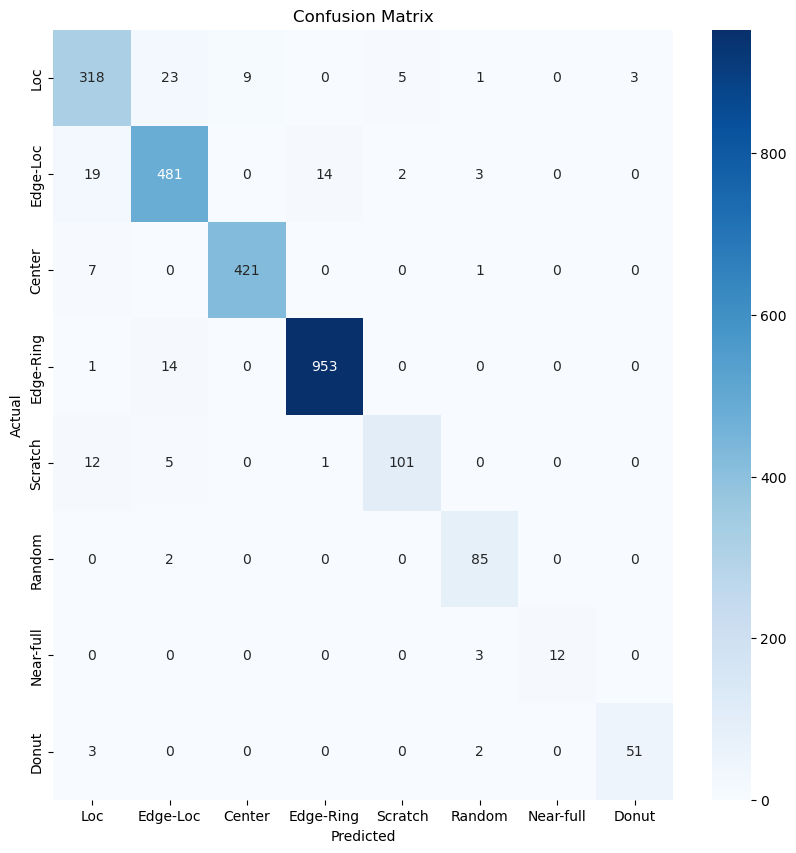


Class Accuracy and Most Common Errors:
Loc: Accuracy: 88.58%
    Most common error: Mistaken for Edge-Loc (6.41%)
Edge-Loc: Accuracy: 92.68%
    Most common error: Mistaken for Loc (3.66%)
Center: Accuracy: 98.14%
    Most common error: Mistaken for Loc (1.63%)
Edge-Ring: Accuracy: 98.45%
    Most common error: Mistaken for Edge-Loc (1.45%)
Scratch: Accuracy: 84.87%
    Most common error: Mistaken for Loc (10.08%)
Random: Accuracy: 97.70%
    Most common error: Mistaken for Edge-Loc (2.30%)
Near-full: Accuracy: 80.00%
    Most common error: Mistaken for Random (20.00%)
Donut: Accuracy: 91.07%
    Most common error: Mistaken for Loc (5.36%)
平均精度：91.44%
8min 16s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [39]:
%%timeit -r 1 -n 1
def plot_confusion_matrix_and_accuracy(y_true, y_pred, classes):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    # Confusion matrixの計算
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # ヒートマップとしてプロット
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # 各クラスごとの正確さと最も間違えやすいクラスを表示
    print("\nClass Accuracy and Most Common Errors:")
    for i, class_name in enumerate(classes):
        accuracy = cm[i, i] / cm[i, :].sum()
        print(f"{class_name}: Accuracy: {accuracy * 100:.2f}%")
        
        # 最も間違えやすいクラスを特定
        error_indices = cm[i, :].argsort()[-2:-1] if accuracy < 1 else []
        for error_index in error_indices:
            error_rate = cm[i, error_index] / cm[i, :].sum()
            error_class = classes[error_index]
            print(f"    Most common error: Mistaken for {error_class} ({error_rate * 100:.2f}%)")

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)
plot_confusion_matrix_and_accuracy(y_test_df['failureType'], user_result_df['failureType'], df['failureType'].unique())

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))
    
    average_accuracy = sum(accuracies.values())/len(accuracies)
print(f"平均精度：{average_accuracy*100:.2f}%")